<a href="https://colab.research.google.com/github/alessandrotofani/Tesi_magistrale/blob/master/7_SHAP_Fed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
from google.colab import drive
drive.mount('/content/drive')
from sklearn.model_selection import train_test_split

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install --quiet fastai==2.2.5

In [3]:
import sys 
sys.path.append('/content/drive/MyDrive/Tesi_magistrale/Tesi_magistrale')
import mf
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Dataset import

In [4]:
data = pd.read_csv('/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/data.csv')
data = mf.new_processing(data)
data = pd.get_dummies(data)
feature_names = mf.get_col(data)

# Model import

## XGBoost

In [5]:
categorical_features = np.arange(178,1091).tolist()

In [6]:
pd.options.mode.chained_assignment = None
X_test = mf.get_set('test_id', data, 'MLP')

**Importante**: se il modello è trainato su GPU, quando si carica bisogna attivare il runtime con GPU, sennò il modello non vine caricato nel modo corretto. 

In [7]:
load = True
if load:
  from tensorflow import keras
  model = keras.models.load_model('/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/MLP/fed_mlp')

Issue: https://github.com/slundberg/shap/issues/452

Vedere https://github.com/dmlc/xgboost/blob/master/demo/gpu_acceleration/shap.ipynb

In [8]:
# booster = xgb.get_booster()
# booster.predict(X_test.to_numpy(), pred_contribs = True, validate_features=False)

# SHAP

**Idea**

A prediction can be explained by assuming that each feature value of the instance is a “player” in a game where the prediction is the payout. Shapley values – a method from coalitional game theory – tells us how to fairly distribute the “payout” among the features.

**Definition**

The Shapley value is the average marginal contribution of a feature value across all possible coalitions. 

The Shapley value is NOT the difference in prediction when we would remove the feature from the model. 

**Interpretation**

Given the current set of feature values, the contribution of a feature value to the difference between the actual prediction and the mean prediction is the estimated Shapley value.

**Theoretical algorithm**

Per determinare il valore di Shapley della feature x_j, si elimina la feature dal dataset, e delle altre si fanno tutte le possibili estrazioni, andando a fare la predizione solo con le feature selezionate e aggiungendo x_j. Facendo la differenza tra ogni predizione con e senza x_j si ottiene il contributo marginale di x_j. 
Per fare la predizione con il modello quando delle feature sono state eliminate, si rimpiazzano i loro valori con valori random (ovviamente tra quelli delle feature rimosse) estratti dal dataset. 


**Implementation**

SHAP turns the Shapley values method into an optimization problem and uses a special kernel function to measure proximity of data instances. The results of SHAP are sparse

**Riferimenti**

Repo github: https://github.com/slundberg/shap

Tutorial (vedere parte per RF): https://towardsdatascience.com/explain-any-models-with-the-shap-values-use-the-kernelexplainer-79de9464897a

Grafici con codice funzionante: https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models/Census%20income%20classification%20with%20LightGBM.html?highlight=classification



In [9]:
!pip install --quiet shap

In [10]:
import shap
shap.initjs()

explainer = shap.KernelExplainer(model.predict, shap.sample(X_test.to_numpy(), 40))

In [11]:
X_test

TransactionDT  TransactionAmt  ...  browser_name_silk  browser_name_waterfox
174364       0.235124        0.002018  ...                  0                      0
418646       0.668431        0.001213  ...                  0                      0
280748       0.428839        0.001349  ...                  0                      0
582196       0.983185        0.003656  ...                  0                      0
420118       0.670400        0.001411  ...                  0                      0
...               ...             ...  ...                ...                    ...
257079       0.385830        0.000536  ...                  0                      0
396902       0.630514        0.001494  ...                  0                      0
473265       0.772798        0.001840  ...                  0                      0
152944       0.196282        0.001389  ...                  0                      0
425280       0.679280        0.006662  ...                  0                      0

[118107 rows x 733 columns]

In [12]:
predictions = model.predict(X_test[:100])

In [13]:
indici = [i for i,x in enumerate(predictions) if x>0.5]

In [14]:
lista = np.arange(100,120).tolist()
x = X_test.iloc[indici].to_numpy()
y = X_test.iloc[lista].to_numpy()
z = np.concatenate((x,y), axis=0)
kernel_shap = explainer.shap_values(z) #sono i valori di shapley
# kernel_shap[1].shape

In [100]:
def get_highest_shap_values(kernel_shap, id):
  import operator
  first_shap = kernel_shap[id][0,:]
  values = {}
  shap_values = {}
  for val in first_shap:
    if val != 0:
      col_index = first_shap.tolist().index(val)
      values[feature_names[col_index]] = x[id][col_index]
      shap_values[feature_names[col_index]] = val

  sorted_d = dict(sorted(shap_values.items(), key=operator.itemgetter(1), reverse=True))
  # return shap_values, values
  return sorted_d, shap_values, values

sorted_shap_values, shap_values, values = get_highest_shap_values(kernel_shap, 0)
print('Sorted shap values: ', sorted_shap_values)
print('Shap values: ', shap_values)
print('Feature values: ', values)

Sorted shap values:  {'browser_name_waterfox': 0.1283482869671857, 'browser_name_silk': 0.0793891314520685, 'browser_name_seamonkey': 0.07728715334887204, 'browser_name_samsung': 0.07020655995791847, 'browser_name_safari': 0.058037265651232794, 'browser_name_puffin': 0.035410692424616974, 'browser_name_palemoon': 0.03450950396231173, 'browser_name_other': 0.03027452021990945, 'browser_name_opera': 0.029820146809559023, 'browser_name_mobile': 0.029027491903983405, 'browser_name_maxthon': 0.027269841112648685, 'browser_name_line': 0.02437822491331121, 'browser_name_iron': 0.022848677729956912, 'browser_name_ie': 0.021285872395547134, 'browser_name_icedragon': 0.021077912527701637, 'browser_name_google': 0.019086527308168733, 'browser_name_firefox': 0.016885080781263967, 'browser_name_facebook': 0.01643461863750606, 'browser_name_edge': 0.015712871810680096, 'browser_name_cyberfox': 0.015349140148319201, 'browser_name_comodo': 0.015164538607113864, 'browser_name_chromium': 0.0149432466974

In [16]:
shap.initjs()
shap.force_plot(explainer.expected_value, kernel_shap[0][0,:], feature_names=feature_names)

In [17]:
shap.initjs()
shap.force_plot(explainer.expected_value, kernel_shap[0][1,:], feature_names=feature_names)

In [18]:
shap.initjs()
shap.force_plot(explainer.expected_value, kernel_shap[0][2,:], feature_names=feature_names)

In [19]:
shap.initjs()
shap.force_plot(explainer.expected_value, kernel_shap[0][3,:], feature_names=feature_names)

In [20]:
shap.initjs()
shap.force_plot(explainer.expected_value, kernel_shap[0][8,:], feature_names=feature_names)

In [21]:
shap.initjs()
shap.force_plot(explainer.expected_value, kernel_shap[0][12,:], feature_names=feature_names)

In [22]:
shap.initjs()
shap.force_plot(explainer.expected_value, kernel_shap[0][13,:], feature_names=feature_names)

In [23]:
shap.initjs()
shap.force_plot(explainer.expected_value, kernel_shap[0][14,:], feature_names=feature_names)

In [24]:
shap.initjs()
shap.force_plot(explainer.expected_value, kernel_shap[0][15,:], feature_names=feature_names)

In [25]:
shap.initjs()
shap.force_plot(explainer.expected_value, kernel_shap[0][16,:], feature_names=feature_names)

In [26]:
shap.initjs()
shap.force_plot(explainer.expected_value, kernel_shap[0][18,:], feature_names=feature_names)

In [27]:
shap.initjs()
shap.force_plot(explainer.expected_value, kernel_shap[0][19,:], feature_names=feature_names)

In [32]:
shap.initjs()
shap.force_plot(explainer.expected_value, kernel_shap[0], feature_names=feature_names)

Decision plot: https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/decision_plot.html?highlight=plot

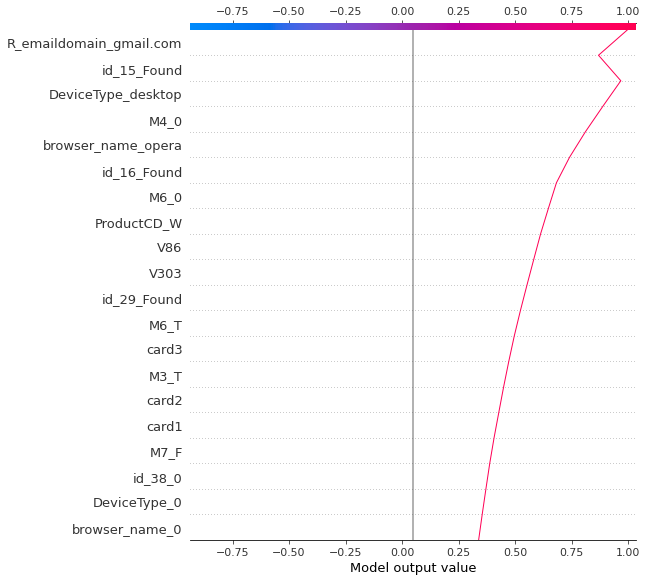

In [34]:
shap.decision_plot(explainer.expected_value, kernel_shap[0][0,:], feature_names=feature_names)

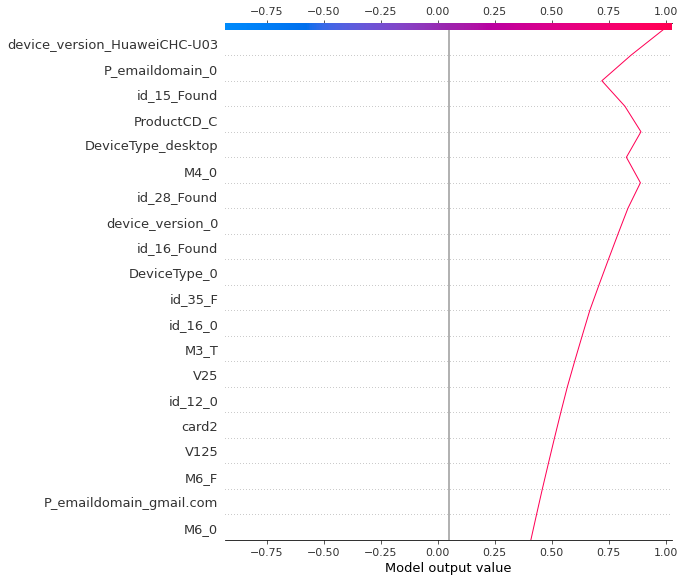

In [35]:
shap.decision_plot(explainer.expected_value, kernel_shap[0][1,:], feature_names=feature_names)

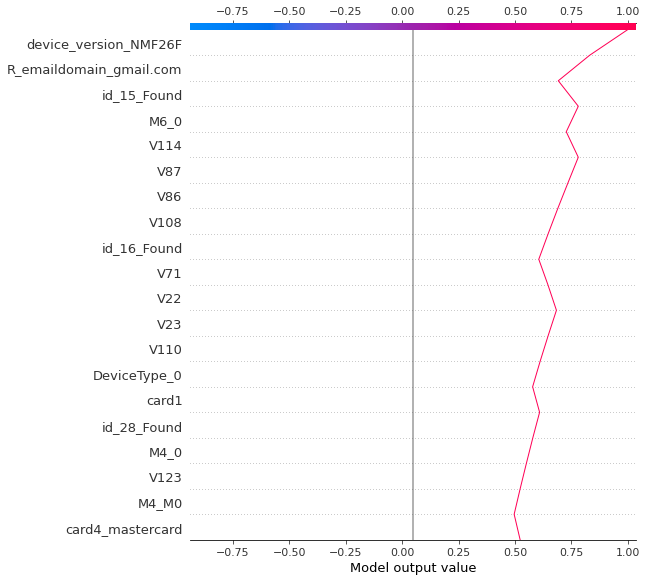

In [36]:
shap.decision_plot(explainer.expected_value, kernel_shap[0][2,:], feature_names=feature_names)

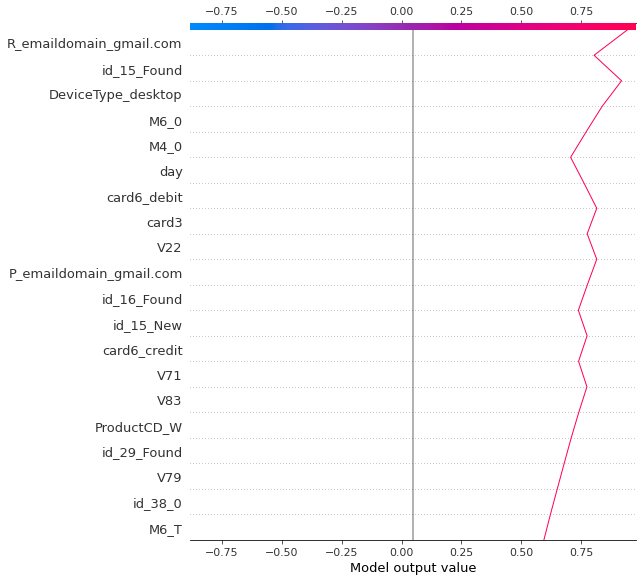

In [37]:
shap.decision_plot(explainer.expected_value, kernel_shap[0][3,:], feature_names=feature_names)

In [88]:
summary = np.asmatrix(kernel_shap[0])

In [89]:
summary

matrix([[-0.0987673 , -0.00179553, -0.00155927, ...,  0.07728715,
          0.07938913,  0.12834829],
        [ 0.00925527,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        , -0.03086204, ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [-0.00405095,  0.        ,  0.00131274, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.00701285,  0.        , -0.02400109, ...,  0.        ,
          0.        ,  0.        ],
        [-0.04720996,  0.        , -0.00827905, ...,  0.        ,
          0.        ,  0.        ]])

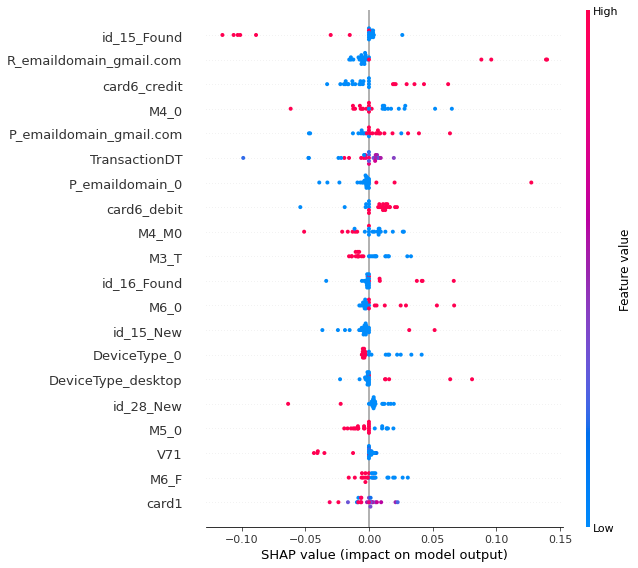

In [103]:
shap.summary_plot(kernel_shap[0], z, feature_names=feature_names)